# Prediction of the Box-Counting Dimension of Metal Nanoparticles: Models Training and Evaluation (Data-Driven Reduction)

This notebook contains the models training and evaluation results from the machine learning predictions of the box-counting dimensions, $D_B$, computed for monometallic gold, palladium, and platinum nanoparticles, in attempt to explore the possibility of using a machine learning model to compute the $D_B$ values to save computational costs. The feature importance profiles are also studied to investigate the most influential features in the prediction of the $D_B$ of metal nanoparticles.

The $D_B$ values are computed using [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of atomistic objects via box-counting approaches.

## Outline

[Notebook Setups](#setup)

[Monometallic Nanoparticles](#mnps)

<a id='setup'></a>
## Notebook Setups

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant libraries
from os import chdir, listdir
from os.path import exists
import pickle
import warnings

import lightgbm
import scipy
import seaborn as sns
import sklearn

from lightgbm import LGBMRegressor
from natsort import natsorted
from scipy import stats
# from sklearnex import patch_sklearn; 
# patch_sklearn()
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.linear_model import ElasticNetCV, LassoLarsCV, LinearRegression, RidgeCV  # To be removed after debugging

# chdir('/scratch/q27/jt5911')
from trainEvalModels import *

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  lightgbm: {lightgbm.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  scipy: {scipy.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")
print(f"  seaborn: {sns.__version__}")

/home/jonting/anaconda3/envs/npfd/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


Versions of imported libraries:
  lightgbm: 4.0.0
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  scipy: 1.11.1
  scikit-learn: 1.4.0
  seaborn: 0.12.2


Below are some general settings for plotting figures:

In [3]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, fontSize, labelSize = (3.5, 2.5), 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

In [4]:
# Global variables
SCALING = 'minmax'  # {None, 'minmax', 'standard', 'yeo-johnson'}
POLY_FEATS = False
FIG_NAME_APPENDIX = 'minmax'
NUM_JOBS = 48
VERBOSE = True
RANDOM_SEED = 42

DATA_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/data'
FIG_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/figs'

In [5]:
def rmNullFeats(featsDF, verbose=False):
    if verbose:
        print(f"Removing the features with null values...")
        print(f"  Original number of features: {len(featsDF.columns)}")
    featsToDrop = []
    for feat in featsDF.columns:
        if featsDF[feat].isnull().any():
            featsToDrop.append(feat)
    featsNoNullDF = featsDF.drop(featsToDrop, axis=1, inplace=False)
    if verbose:
        print(f"  Total number of features left: {len(featsNoNullDF.columns)}\n")
    return featsNoNullDF

In [6]:
def genModel(hpValDict, modelName):
    if modelName == 'RFR':
        kwargs = {'n_estimators': 100, 'criterion': 'squared_error', 
                  # Adjust to deal with overfitting and speed up training
                  'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 
                  'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'ccp_alpha': 0.0, 
                  # Parameters to be fixed
                  'min_weight_fraction_leaf': 0.0, 'bootstrap': True, 'warm_start': False, 
                  'monotonic_cst': None, 'oob_score': False, 'n_jobs': NUM_JOBS, 'random_state': RANDOM_SEED, 'verbose': 0}
    elif modelName == 'LGB':
        kwargs = {'num_leaves': 31, 'min_child_samples': 20, 'learning_rate': 0.1, 'n_estimators': 100, 
                  # Adjust to deal with overfitting
                  'min_child_weight': 0.001, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 
                  'subsample': 1.0, 'subsample_freq': 0, 'colsample_bytree': 1.0, 
                  # Adjust to speed up training
                  'min_split_gain': 0.0, 'subsample_for_bin': 200000, 'max_bin': 255, 'max_depth': -1, 
                  # Parameters to be fixed
                  'boosting_type': 'gbdt', 'importance_type': 'gain', 'tree_learner': 'data', 
                  'objective': 'regression', 'class_weight': None, 'use_missing': True,
                  'random_state': RANDOM_SEED, 'n_jobs': NUM_JOBS, 'force_row_wise': True, 'verbose': -1}

    for hp in hpValDict.keys():
        kwargs[hp] = hpValDict[hp]
        
    if modelName == 'RFR':
        return RandomForestRegressor(**kwargs)
    elif modelName == 'LGB':
        return LGBMRegressor(**kwargs)

In [7]:
def getTrainTestScores(dataset, hpsValsDicts, modelName):
    Xtrain, Xtest, yTrain, yTest = dataset
    trainScores, testScores = [], []
    for hpsValsDict in hpsValsDicts:
        reg = genModel(hpsValsDict, modelName)
        reg.fit(Xtrain, yTrain)
        trainScores.append(reg.score(Xtrain, yTrain))
        testScores.append(reg.score(Xtest, yTest))
    return trainScores, testScores

In [8]:
def hpVSr2(xVals, scores, xlabel, figSize=(7, 2.5)):
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#303F9F', '#FF5252', '#D32F2F'])
    if len(scores) == 1:
        trainScores, testScores = scores[0]
        plt.figure(figsize=figSize)
        if all(isinstance(xVal, str) for xVal in xVals):
            plt.bar(xVals, trainScores)
            plt.bar(xVals, testScores)
        else:
            plt.plot(xVals, trainScores)
            plt.plot(xVals, testScores)
            plt.xlabel(xlabel)
        plt.grid(linestyle='dotted')
        plt.ylabel('R2 score')
        plt.legend(['Train', 'Test']);
    else:
        fig, axes = plt.subplots(1, len(scores), figsize=figSize)
        for i, (trainScores, testScores) in enumerate(scores):
            if all(isinstance(xVal, str) for xVal in xVals):
                axes[i].bar(xVals, trainScores)
                axes[i].bar(xVals, testScores)
            else:
                axes[i].plot(xVals, trainScores)
                axes[i].plot(xVals, testScores)
            axes[i].grid(linestyle='dotted')
            axes[i].legend(['Train', 'Test'])
        fig.text(0.5, -0.03, xlabel, ha='center')
        fig.text(0.05, 0.5, 'R2 score', va='center', rotation='vertical');

<a id='mnps'></a>
## Monometallic Nanoparticles

Here we attempt to train a machine learning model that aims to predict the $D_B$ values of a set of simulated monometallic nanoparticles (either gold, palladium, or platinum), study the feature importance profile to understand the influential features in the prediction of the $D_B$ values, and investigate the conditions that give rise to rougher nanoparticles.

### Data Loading

In [9]:
CORR_THRESH = 0.8

with open(f"{DATA_DIR}/processedMNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'rb') as f:
    MNPDF1 = pickle.load(f)
with open(f"{DATA_DIR}/processedMNPEdataNoC{int(CORR_THRESH * 100)}.pickle", 'rb') as f:
    MNPDF2 = pickle.load(f)
# Total Energy
MNPDF = MNPDF2.iloc[MNPDF1.index, :].iloc[:, :-1]
# Formation Energy
# MNPDF = MNPDF2.iloc[MNPDF1.index, :]
# MNPDF = MNPDF.drop(['Total_E'], axis=1)

MNPNoNullDF = rmNullFeats(featsDF=MNPDF, verbose=VERBOSE)

Removing the features with null values...
  Original number of features: 51
  Total number of features left: 51



The features in the monometallic datasets do not contain any missing values.

In [57]:
XtrainMNP, XtestMNP, yTrainMNP, yTestMNP = splitScaleData(df=MNPDF, polyFeats=POLY_FEATS, scaling=SCALING, verbose=VERBOSE)
XtrainMNPNoNull, XtestMNPNoNull, yTrainMNPNoNull, yTestMNPNoNull = splitScaleData(df=MNPNoNullDF, polyFeats=POLY_FEATS, scaling=SCALING, verbose=VERBOSE)

X_Y_MNPS = {'WithNull': {'MNP': (XtrainMNP, XtestMNP, yTrainMNP, yTestMNP)}, 
            'NoNull': {'MNP': (XtrainMNPNoNull, XtestMNPNoNull, yTrainMNPNoNull, yTestMNPNoNull)}}

Applying minmax scaling to feature values...
Applying minmax scaling to feature values...


### Models Training and Evaluation

The chosen regression models are trained on the monometallic nanoparticle data set without polynomial features, with features scaled via min-max normalisation.

##### Linear Regressor

Linear regressor is chosen as a baseline. It cannot handle missing values in the features.


Dataset: MNP
  Running LRR
  Trained and tested using Coefficient of determination.
    Training score: 0.672
    Cross-validation score: 0.276 +/- 0.269
    Testing score:
      Mean absolute error: 0.021558
      Mean squared error: 0.000679
      Root mean squared error: 0.026054
      Coefficient of determination: 0.269


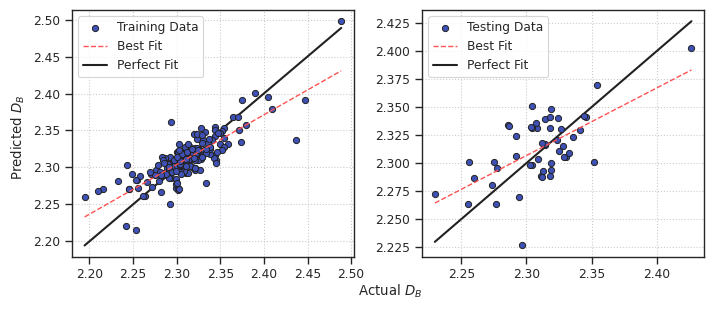

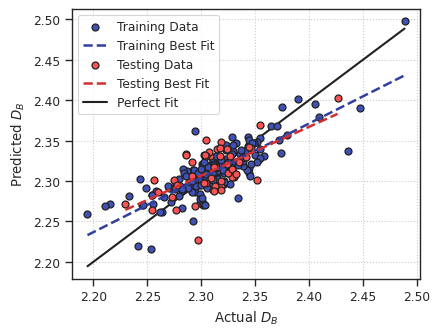

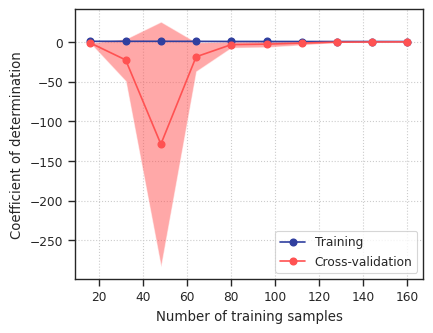

  Feature coefficients:
    time: 0.002
    q6q6_avg_surf: 0.050
    S_100: 0.028
    S_110: 0.106
    S_311: 0.020
    N_atom_surface: 0.378
    R_skew: 0.013
    MM_BCN_avg: 0.026
    MM_BL_min: 0.006
    HCP: 0.012
    ICOS: 0.008
    Curve_11-20: 0.185
    Curve_31-40: 0.069
    MM_SCN_2: 0.003
    MM_SCN_3: 0.005
    MM_SCN_8: 0.012
    MM_SCN_14: 0.018
    MM_SCN_15: 0.020
    q6q6_S_12: 0.025
    q6q6_S_13: 0.006
    MM_TCN_14: 0.022
    MM_TCN_16: 0.002
    MM_BCN_5: 0.006
    MM_BCN_7: 0.010
    MM_BCN_8: 0.021
    q6q6_B_7: 0.143


In [35]:
hasMissingVals, modelName = 'NoNull', 'LRR'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    linReg = LinearRegression(positive=False, fit_intercept=True, 
                              copy_X=True, n_jobs=NUM_JOBS)  # No speedup from n_jobs here as n_target=1 and positive=False
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    yPredTrainLinR, yPredTestLinR, linReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                     model=linReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                     numFeat=20, isReg=True, showFeatCoef=True, plotFeatImp=False, verbose=True, showFig=True)


Dataset: MNP
  Running LRR_totE
  Trained and tested using Coefficient of determination.
    Training score: 0.995
    Cross-validation score: 0.982 +/- 0.006
    Testing score:
      Mean absolute error: 1795.803976
      Mean squared error: 7319996.882419
      Root mean squared error: 2705.549276
      Coefficient of determination: 0.979


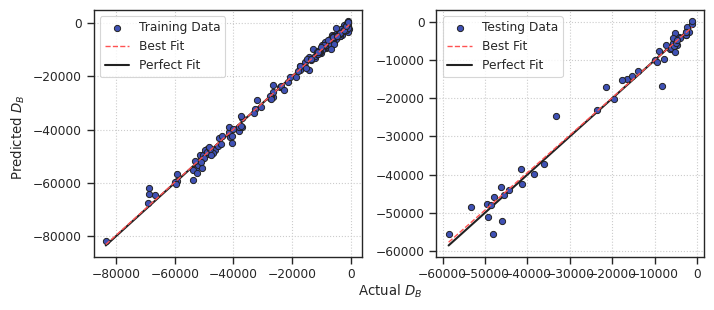

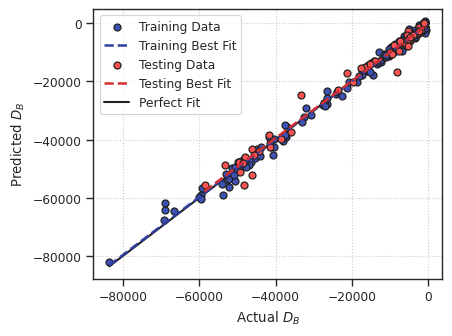

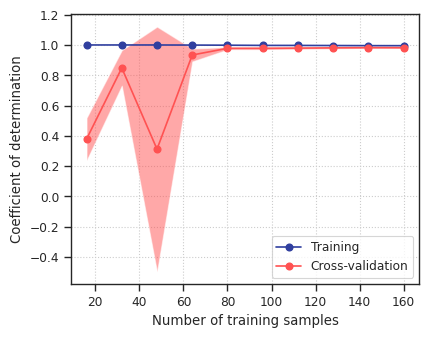

  Feature coefficients:
    time: 427.954
    Volume: 2863.552
    R_diff: 1136.819
    R_kurt: 1930.196
    Curve_11-20: 7927.119
    Curve_31-40: 17126.644
    Curve_61-70: 136.150
    Curve_71-80: 211.494
    MM_TCN_3: 151.321
    MM_TCN_8: 2140.477
    MM_TCN_15: 237.008
    MM_TCN_16: 541.061
    MM_BCN_5: 1766.439
    MM_BCN_8: 5665.891
    MM_SCN_12: 5921.445
    MM_BL_std: 15902.329
    MMM_BA1_avg: 4537.224
    DECA: 4904.801
    q6q6_avg_total: 6847.816
    q6q6_T_4: 7066.352
    q6q6_T_13: 3749.119
    q6q6_S_12: 3589.460


In [44]:
hasMissingVals, modelName = 'NoNull', 'LRR_Etot'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    linReg = LinearRegression(positive=False, fit_intercept=True, 
                              copy_X=True, n_jobs=NUM_JOBS)  # No speedup from n_jobs here as n_target=1 and positive=False
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    yPredTrainLinR, yPredTestLinR, linReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                     model=linReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                     numFeat=20, isReg=True, showFeatCoef=True, plotFeatImp=False, verbose=True, showFig=True)


Dataset: MNP
  Running LRR_formE
  Trained and tested using Coefficient of determination.
    Training score: 0.972
    Cross-validation score: 0.918 +/- 0.029
    Testing score:
      Mean absolute error: 237.343163
      Mean squared error: 128827.240651
      Root mean squared error: 358.925118
      Coefficient of determination: 0.920


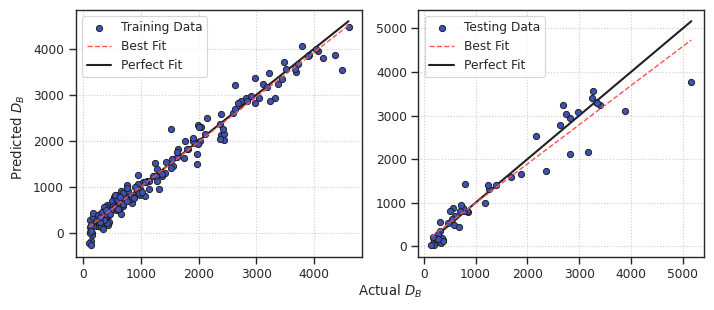

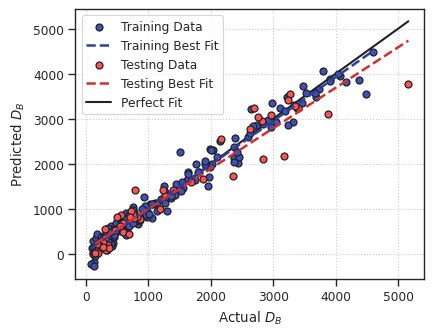

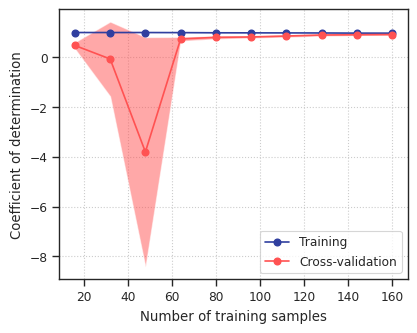

  Feature coefficients:
    T: 487.514
    N_atom_total: 3822.204
    R_diff: 430.469
    R_skew: 44.575
    S_110: 535.600
    Curve_51-60: 572.993
    Curve_61-70: 207.857
    Curve_71-80: 191.991
    MM_BCN_avg: 457.587
    MM_TCN_1: 104.022
    MM_TCN_8: 3902.601
    MM_TCN_11: 924.578
    MM_TCN_15: 224.612
    MM_TCN_16: 54.022
    MM_BCN_8: 65.994
    MM_SCN_13: 200.213
    MM_SCN_14: 5.827
    MM_SCN_15: 19.321
    MM_BL_std: 275.862
    MM_BL_min: 250.298
    MMM_BA1_avg: 1090.109
    DECA: 628.650
    q6q6_T_6: 1657.313
    q6q6_T_13: 802.883


In [53]:
hasMissingVals, modelName = 'NoNull', 'LRR_Eform'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    linReg = LinearRegression(positive=False, fit_intercept=True, 
                              copy_X=True, n_jobs=NUM_JOBS)  # No speedup from n_jobs here as n_target=1 and positive=False
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    yPredTrainLinR, yPredTestLinR, linReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                     model=linReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                     numFeat=20, isReg=True, showFeatCoef=True, plotFeatImp=False, verbose=True, showFig=True)

##### Random Forest Regressor


Dataset: MNP
Best score: 0.524
Best parameter combination: {'criterion': 'poisson', 'max_depth': 8, 'max_features': 0.9610209177153485, 'max_leaf_nodes': 32, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
  Running RFR
  Trained and tested using Coefficient of determination.
    Training score: 0.810
    Cross-validation score: 0.524 +/- 0.084
    Testing score:
      Mean absolute error: 0.016742
      Mean squared error: 0.000504
      Root mean squared error: 0.022448
      Coefficient of determination: 0.457


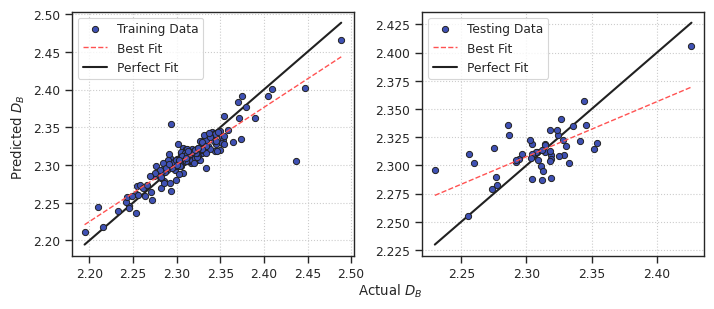

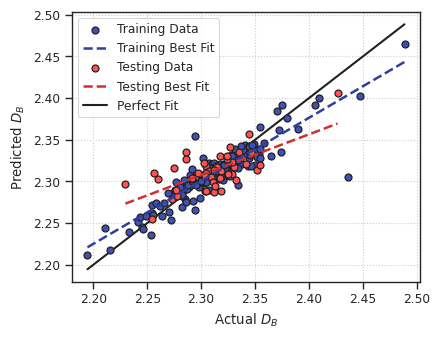

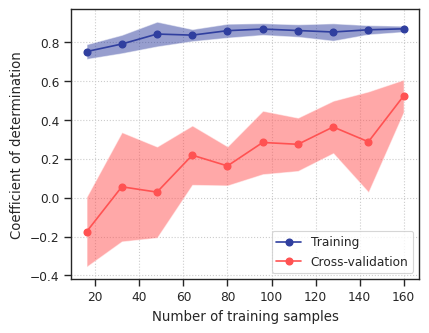

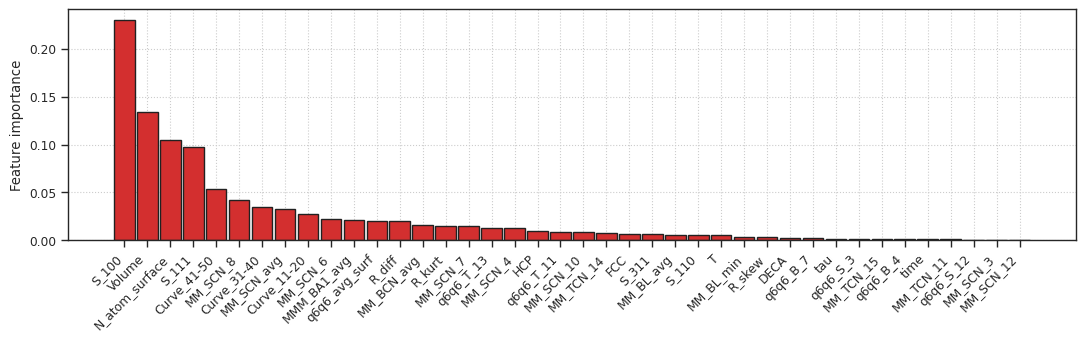

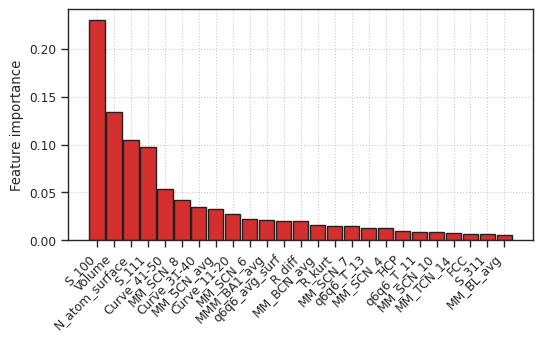

In [48]:
hasMissingVals, modelName = 'WithNull', 'RFR'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    # if exists(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle"):
    #     print('Already done, skipping...')
    #     continue
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    rfReg = RandomForestRegressor(n_estimators=40, criterion='squared_error', max_depth=None, 
                                  max_features=1.0, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, 
                                  min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0, n_jobs=NUM_JOBS, random_state=RANDOM_SEED, verbose=0, 
                                  bootstrap=True, oob_score=False, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
    paramGrid = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 
                 'n_estimators': stats.randint(low=3, high=100), 
                 'max_depth' : stats.randint(low=1, high=10), 
                 'max_features': stats.uniform(loc=0.1, scale=0.9), 
                 'max_leaf_nodes': stats.randint(low=5, high=100),
                 'min_samples_split': stats.randint(low=2, high=20), 
                 'min_samples_leaf': stats.randint(low=1, high=10)}
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    searchResults = hyperparamTune(rfReg, paramGrid, Xtrain, yTrain, scoringMetric='r2', cv=cv, numIter=100000)
    with open(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle", 'wb') as f:
        pickle.dump(searchResults, f)

    rfReg = searchResults.best_estimator_
    yPredTrainRFR, yPredTestRFR, rfReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                  model=rfReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                  numFeat=15, showFeatCoef=False, plotFeatImp=True, verbose=True, showFig=True)
    # # Note: Set 'showFig' to False for cluster jobs!


Dataset: MNP


/home/jonting/anaconda3/envs/npfd/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
1260 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1260 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jonting/anaconda3/envs/npfd/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jonting/anaconda3/envs/npfd/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jonting/anaconda3/envs/npfd/lib/python3

Best score: 0.970
Best parameter combination: {'criterion': 'squared_error', 'max_depth': 6, 'max_features': 0.8197468875683751, 'max_leaf_nodes': 43, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 56}
  Running RFR_Etot
  Trained and tested using Coefficient of determination.
    Training score: 0.995
    Cross-validation score: 0.970 +/- 0.012
    Testing score:
      Mean absolute error: 1539.780615
      Mean squared error: 8730795.608424
      Root mean squared error: 2954.791974
      Coefficient of determination: 0.975


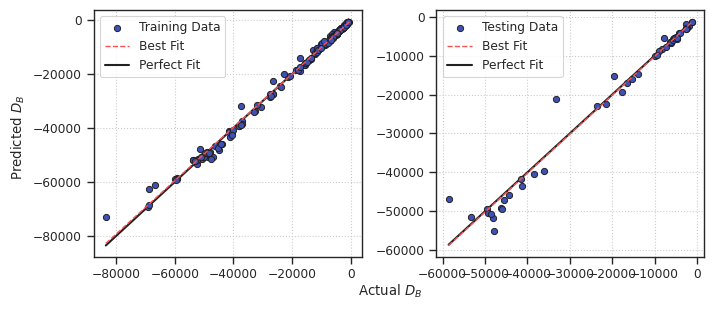

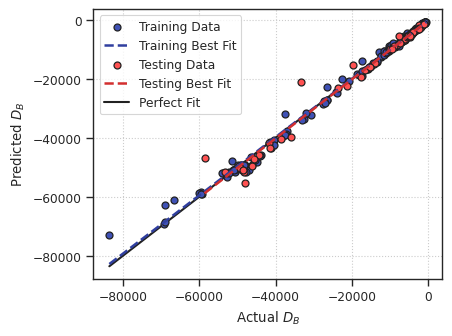

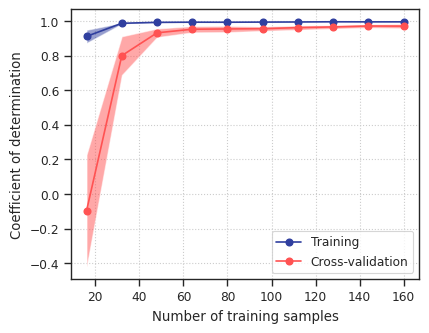

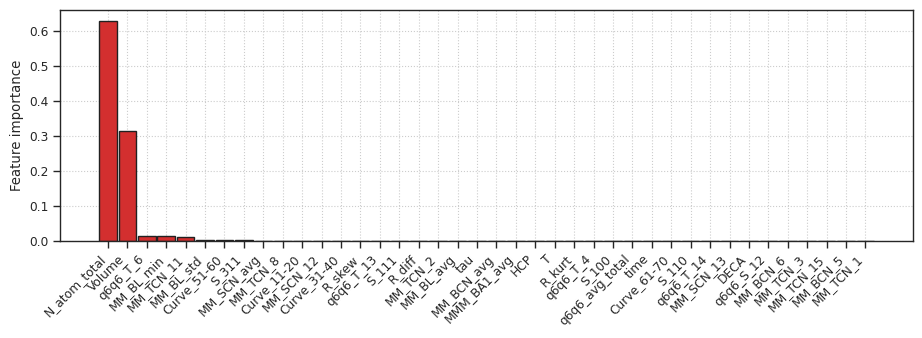

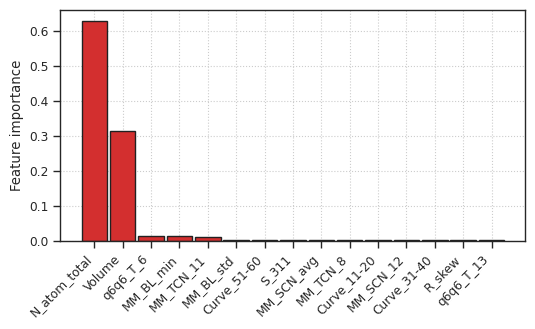

In [58]:
hasMissingVals, modelName = 'WithNull', 'RFR_Etot'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    # if exists(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle"):
    #     print('Already done, skipping...')
    #     continue
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    rfReg = RandomForestRegressor(n_estimators=40, criterion='squared_error', max_depth=None, 
                                  max_features=1.0, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, 
                                  min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0, n_jobs=NUM_JOBS, random_state=RANDOM_SEED, verbose=0, 
                                  bootstrap=True, oob_score=False, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
    paramGrid = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 
                 'n_estimators': stats.randint(low=3, high=100), 
                 'max_depth' : stats.randint(low=1, high=10), 
                 'max_features': stats.uniform(loc=0.1, scale=0.9), 
                 'max_leaf_nodes': stats.randint(low=5, high=100),
                 'min_samples_split': stats.randint(low=2, high=20), 
                 'min_samples_leaf': stats.randint(low=1, high=10)}
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    searchResults = hyperparamTune(rfReg, paramGrid, Xtrain, yTrain, scoringMetric='r2', cv=cv, numIter=1000)
    with open(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle", 'wb') as f:
        pickle.dump(searchResults, f)

    rfReg = searchResults.best_estimator_
    yPredTrainRFR, yPredTestRFR, rfReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                  model=rfReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                  numFeat=15, showFeatCoef=False, plotFeatImp=True, verbose=True, showFig=True)
    # # Note: Set 'showFig' to False for cluster jobs!


Dataset: MNP
Best score: 0.878
Best parameter combination: {'criterion': 'squared_error', 'max_depth': 8, 'max_features': 0.7099509170811884, 'max_leaf_nodes': 72, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 9}
  Running RFR_Eform
  Trained and tested using Coefficient of determination.
    Training score: 0.975
    Cross-validation score: 0.878 +/- 0.050
    Testing score:
      Mean absolute error: 217.900716
      Mean squared error: 149664.466577
      Root mean squared error: 386.864920
      Coefficient of determination: 0.907


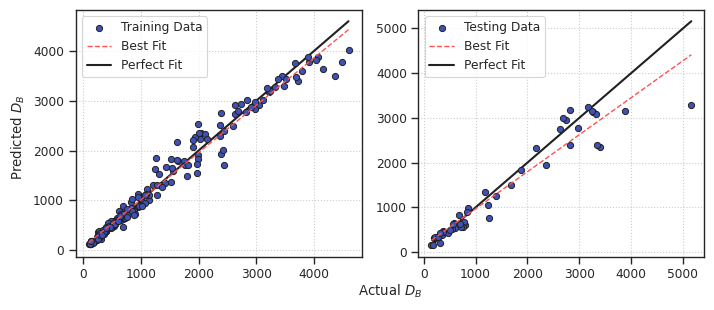

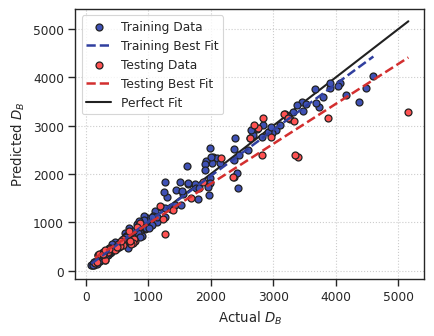

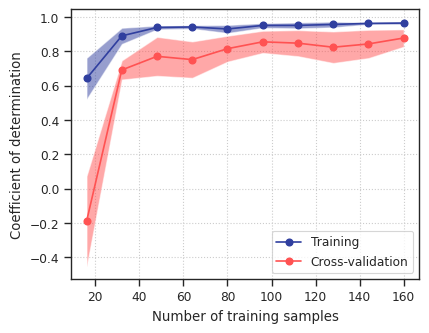

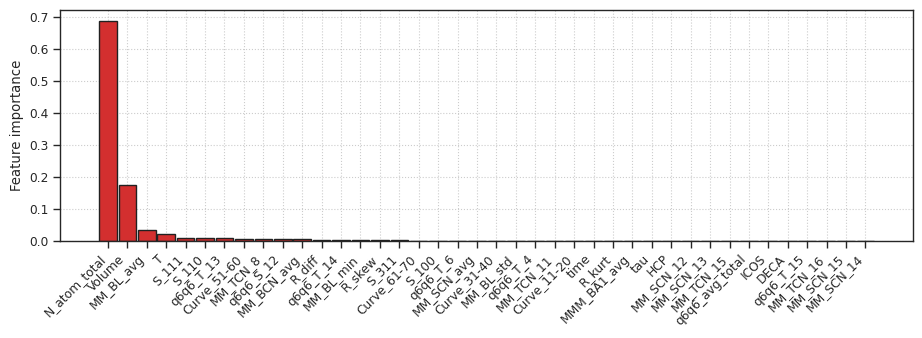

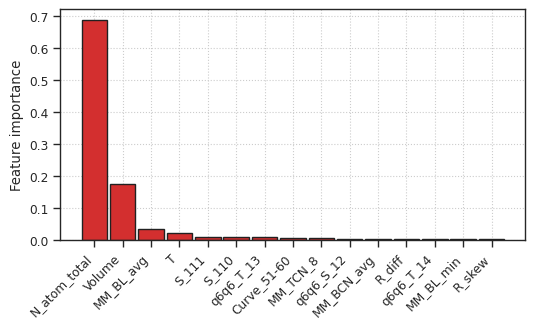

In [55]:
hasMissingVals, modelName = 'WithNull', 'RFR_Eform'
for mnp in X_Y_MNPS[hasMissingVals].keys():
    print(f"\nDataset: {mnp}")
    # if exists(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle"):
    #     print('Already done, skipping...')
    #     continue
    Xtrain, Xtest, yTrain, yTest = X_Y_MNPS[hasMissingVals][mnp]
    
    rfReg = RandomForestRegressor(n_estimators=40, criterion='squared_error', max_depth=None, 
                                  max_features=1.0, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, 
                                  min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0, n_jobs=NUM_JOBS, random_state=RANDOM_SEED, verbose=0, 
                                  bootstrap=True, oob_score=False, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
    paramGrid = {'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 
                 'n_estimators': stats.randint(low=3, high=100), 
                 'max_depth' : stats.randint(low=1, high=10), 
                 'max_features': stats.uniform(loc=0.1, scale=0.9), 
                 'max_leaf_nodes': stats.randint(low=5, high=100),
                 'min_samples_split': stats.randint(low=2, high=20), 
                 'min_samples_leaf': stats.randint(low=1, high=10)}
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    searchResults = hyperparamTune(rfReg, paramGrid, Xtrain, yTrain, scoringMetric='r2', cv=cv, numIter=1000)
    with open(f"{DATA_DIR}/hpTune{mnp}{modelName}.pickle", 'wb') as f:
        pickle.dump(searchResults, f)

    rfReg = searchResults.best_estimator_
    yPredTrainRFR, yPredTestRFR, rfReg = runModel(Xtrain, yTrain, Xtest, yTest, cv,
                                                  model=rfReg, modelName=modelName, datasetName=mnp, figNameAppendix=FIG_NAME_APPENDIX,
                                                  numFeat=15, showFeatCoef=False, plotFeatImp=True, verbose=True, showFig=True)
    # # Note: Set 'showFig' to False for cluster jobs!

In [53]:
numFeats = 40
featImps = []
for (i, feat) in enumerate(rfReg.feature_names_in_):
    featImps.append((feat, rfReg.feature_importances_[i]))
print(f"Top {numFeats} most important features:")
topImpFeats = [featScoreTup[0] for featScoreTup in sorted(featImps, key=lambda x: x[1], reverse=True)[:numFeats]]
print(topImpFeats)

Top 40 most important features:
['S_100', 'Volume', 'N_atom_surface', 'S_111', 'Curve_41-50', 'MM_SCN_8', 'Curve_31-40', 'MM_SCN_avg', 'Curve_11-20', 'MM_SCN_6', 'MMM_BA1_avg', 'q6q6_avg_surf', 'R_diff', 'MM_BCN_avg', 'R_kurt', 'MM_SCN_7', 'q6q6_T_13', 'MM_SCN_4', 'HCP', 'q6q6_T_11', 'MM_SCN_10', 'MM_TCN_14', 'FCC', 'S_311', 'MM_BL_avg', 'S_110', 'T', 'MM_BL_min', 'R_skew', 'DECA', 'q6q6_B_7', 'tau', 'q6q6_S_3', 'MM_TCN_15', 'q6q6_B_4', 'time', 'MM_TCN_11', 'q6q6_S_12', 'MM_SCN_3', 'MM_SCN_12']


In [54]:
df = MNPDF[topImpFeats + ['DBoxEX']]
df.to_csv(f"{DATA_DIR}/MNPimpFeats.csv", sep=',', index=False)

### Causal Feature Analysis

In [10]:
df = MNPDF1
df

,T,time,tau,MM_SCN_avg,q6q6_avg_surf,S_100,S_111,S_110,S_311,N_atom_surface,...,q6q6_T_11,q6q6_T_13,q6q6_T_15,MM_BCN_5,MM_BCN_6,MM_BCN_7,MM_BCN_8,q6q6_B_4,q6q6_B_7,DBoxEX
3008,823,9,0.000025,8.6280,0.6003,7,100,185,26,2637,...,0,0,0,0,0,0,4,153,18,2.328287
3908,973,9,0.000025,8.4562,0.4404,5,49,181,21,2670,...,0,0,0,0,0,0,12,79,6,2.321823
8006,303,7,0.000025,8.1660,6.7229,42,187,164,224,2717,...,1070,47,0,0,0,0,0,169,525,2.308326
4909,373,10,0.000025,8.5551,6.7733,51,210,334,196,2841,...,874,543,0,0,0,0,1,147,172,2.318217
8436,473,7,0.000100,8.0421,6.9520,52,165,185,167,2541,...,554,3,0,0,0,0,0,26,221,2.297734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9013,673,10,0.000000,8.3417,8.1774,0,117,114,44,761,...,146,2,0,0,0,0,0,0,0,2.258592
185,303,6,0.000225,8.6300,6.2743,1,112,145,9,627,...,115,185,0,0,0,0,0,2,16,2.291774
4534,323,10,0.000000,8.4306,8.4117,24,168,310,0,634,...,143,1,0,0,0,0,0,0,0,2.291620
7711,923,10,0.000000,8.4064,7.1438,45,169,88,80,1196,...,200,196,0,0,0,0,0,2,4,2.300446


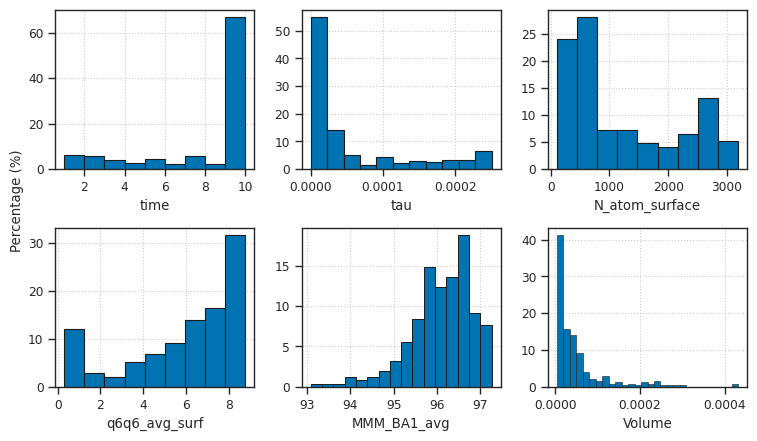

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(7.5, 4.5), dpi=DPI)   # , sharey=True
sns.histplot(data=df, x='time', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[0, 0],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[0, 0].set_ylabel('')
axs[0, 0].grid(linestyle='dotted')
sns.histplot(data=df, x='tau', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[0, 1],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[0, 1].set_ylabel('')
axs[0, 1].grid(linestyle='dotted')
sns.histplot(data=df, x='N_atom_surface', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[0, 2],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[0, 2].set_ylabel('')
axs[0, 2].grid(linestyle='dotted')
sns.histplot(data=df, x='q6q6_avg_surf', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[1, 0],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[1, 0].set_ylabel('')
axs[1, 0].grid(linestyle='dotted')
sns.histplot(data=df, x='MMM_BA1_avg', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[1, 1],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[1, 1].set_ylabel('')
axs[1, 1].grid(linestyle='dotted')
sns.histplot(data=df, x='Volume', hue=None,
             palette=None, edgecolor='k', alpha=1.0, multiple='layer', element='bars', fill=True, ax=axs[1, 2],
             stat='percent', bins='auto', common_norm=False, kde=False)
axs[1, 2].set_ylabel('')
axs[1, 2].set_xticks([0.0000, 0.0002, 0.0004])
axs[1, 2].grid(linestyle='dotted')
fig.text(-0.005, 0.545, 'Percentage (%)', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/DBoxFeatsRange.png", bbox_inches='tight')